In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import glob

In [135]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

In [136]:
client.cluster

In [236]:
#locate the output files
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h0'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1985
files = np.array(files)[yrs>=yr0]

In [237]:
def preprocess(ds):
    dvs=['TLAI','GPP','ER','SOILWATER_10CM','EFLX_LH_TOT','TV']
    return ds[dvs]
ds = xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                       decode_times=False,preprocess=preprocess)
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')

In [183]:
def gmean(da,la,cf=None):
    '''
    g defines the averaging group,
    g=[] is global, otherwise use ds.biome or ds.pft
    '''
    
    if not cf:
        cf=1/la.sum()
    
    x=cf*(da*la).sum(dim=['lat','lon'])

    
    return x.compute()

In [140]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    return xa


In [147]:
sg=xr.open_dataset(files[0])

In [162]:
def sg_rmse(file,x):
    sg=xr.open_dataset(file)
    xv=np.zeros(len(sg.numclust)+1)+np.nan
    ix=sg.rcent.values[sg.rcent>0].astype(int)
    xv[ix]=x[sg.rcent>0]
    c=sg.cclass.values.ravel()
    c=c[c>0].astype(int)
    mapped=np.zeros(x.shape)+np.nan
    mapped[sg.cclass>0]=xv[c]
    rmse=np.sqrt(np.nanmean((x-mapped)**2))/np.nanmean(mapped)
    ix=mapped.ravel()>=0
    r2=np.corrcoef(x.ravel()[ix],mapped.ravel()[ix])[0,1]**2
    return rmse,r2

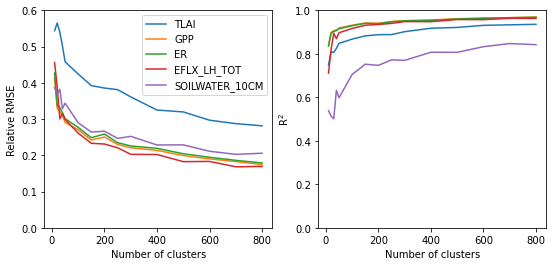

In [173]:
plt.figure(figsize=[9,4])
for v in ['TLAI','GPP','ER','EFLX_LH_TOT','SOILWATER_10CM',]:
    x=amean(ds[v]).mean(dim='year').values
    x[~(sg.landfrac>0)]=np.nan
    out=[sg_rmse(file,x) for file in files]
    rmse=[o[0] for o in out]
    r2  =[o[1] for o in out]

    plt.subplot(121)
    plt.plot(nclust,rmse,label=v)
    plt.subplot(122)
    plt.plot(nclust,r2,label=v)
plt.subplot(121)
plt.xlabel('Number of clusters')
plt.ylabel('Relative RMSE')
plt.ylim([0,0.6])
plt.legend()
plt.subplot(122)
plt.ylabel(r'R$^2$')
plt.xlabel('Number of clusters')
plt.ylim([0,1]);
plt.savefig('../figs/sparsegrid_rmse.pdf',bbox_inches='tight')

In [238]:
def gppg(file,x):
    sg=xr.open_dataset(file)
    xv=np.zeros(len(sg.numclust)+1)+np.nan
    ix=sg.rcent.values[sg.rcent>0].astype(int)
    xv[ix]=x[sg.rcent>0]
    c=sg.cclass.values.ravel()
    c=c[c>0].astype(int)
    mapped=np.zeros(x.shape)+np.nan
    mapped[sg.cclass>0]=xv[c]
    
    return gmean(mapped,la,cf=1e-9)

In [227]:
def get_gpp(file):
    sg=xr.open_dataset(file)
    xv=np.zeros([gpp.shape[0],len(sg.numclust)+1])+np.nan
    ix=sg.rcent.values[sg.rcent>0].astype(int)
    xv[:,ix]=gpp[:,sg.rcent>0]
    c=sg.cclass.values.ravel()
    c=c[c>0].astype(int)
    mapped=np.zeros(gpp.shape)+np.nan
    mapped[:,sg.cclass>0]=xv[:,c]
    out=xr.DataArray(mapped,dims=['year','lat','lon'])
    gppsg=gmean(out,la,cf=1e-9)
    return gppsg

In [242]:
d='/glade/u/home/forrest/ppe_representativeness/output_v4/'
files=np.array(glob.glob(d+'*annual+sd*'))
ix=np.argsort(np.array([f.split('.')[-2] for f in files]).astype(int))
files=files[ix]

In [239]:
gpp0=amean(ds.GPP,cf=24*60*60)
gpp=gpp0.values
gpp[:,~(sg.landfrac>0)]=np.nan

la=sg.landfrac*sg.area
gppfg=gmean(gpp0,la,cf=1e-9)

In [244]:
rmse=np.zeros(len(files))
r2=np.zeros(len(files))
for i,file in enumerate(files):
    gppsg=get_gpp(file)
    rmse[i]=np.sqrt(np.mean((gppfg-gppsg)**2))
    r2[i]=np.corrcoef(gppfg,gppsg)[0,1]**2

(0.0, 1.0)

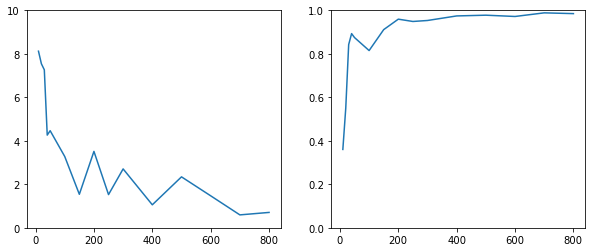

In [249]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot(nclust,rmse)
plt.ylim([0,10])

plt.subplot(122)
plt.plot(nclust,r2)
plt.ylim([0,1])

In [257]:
len(files)

15

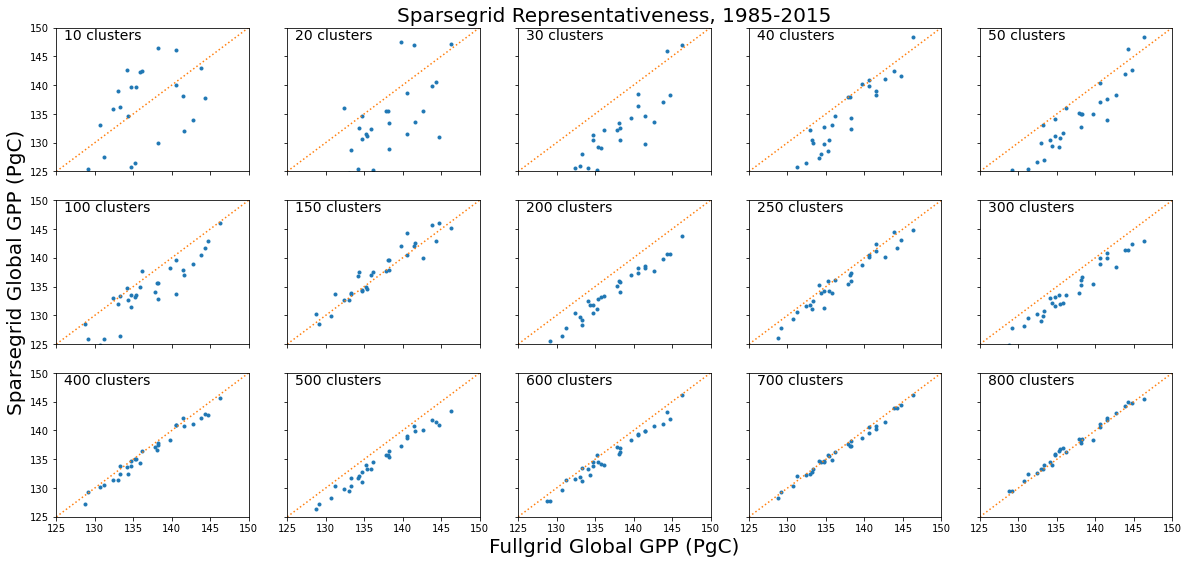

In [275]:
plt.figure(figsize=[20,9])

for i,file in enumerate(files):

    gppsg=get_gpp(file)

    plt.subplot(3,5,i+1)
    plt.plot(gppfg,gppsg,'.')
    plt.plot([125,150],[125,150],':')
    plt.xlim([125,150])
    plt.ylim([125,150])
    c=file.split('.')[-2]
    plt.text(126,148,c+' clusters',fontsize=14)
    
    if (i%5)>0:
        plt.yticks(range(125,155,5),'')
        
    if i<10:
        plt.xticks(range(125,155,5),'')
        
        
    if i==12:
        plt.xlabel('Fullgrid Global GPP (PgC)',fontsize=20)
        
    if i==5:
        plt.ylabel('Sparsegrid Global GPP (PgC)',fontsize=20)
    
    if i==2:
        plt.title('Sparsegrid Representativeness, 1985-2015',fontsize=20)
        
plt.savefig('../figs/sparsegrid_gpp.pdf',bbox_inches='tight')

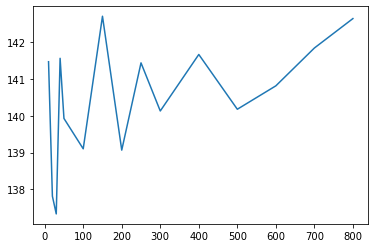

In [190]:
plt.plot(nclust,gpps)

In [110]:
file=files[10]
sg=xr.open_dataset(file)
xv=np.zeros(len(sg.numclust)+1)+np.nan
ix=sg.rcent.values[sg.rcent>0].astype(int)
xv[ix]=x[sg.rcent>0]
c=sg.cclass.values.ravel()
c=c[c>0].astype(int)
mapped=np.zeros(x.shape)+np.nan
mapped[sg.cclass>0]=xv[c]

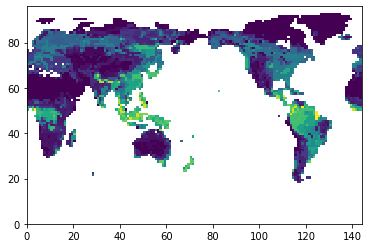

In [112]:
plt.pcolormesh(mapped)

(0.0, 12.0)

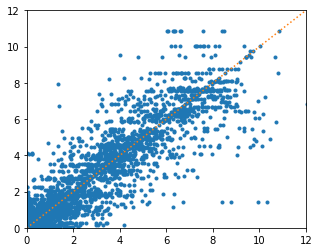

In [122]:
plt.figure(figsize=[5,4])
plt.plot(x.ravel(),mapped.ravel(),'.')
plt.plot([0,12],[0,12],':')
plt.xlim([0,12])
plt.ylim([0,12])

array([[1.        , 0.82128735],
       [0.82128735, 1.        ]])

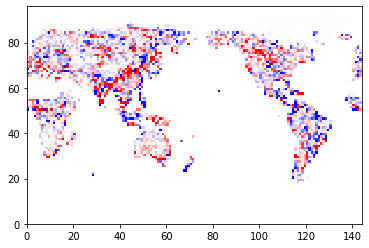

In [116]:
plt.pcolormesh(x-mapped,vmin=[-2,2],cmap='bwr')

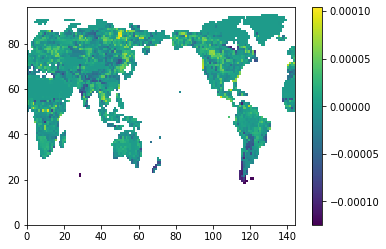

In [77]:
plt.pcolormesh(gpp-mapped)
plt.colorbar()

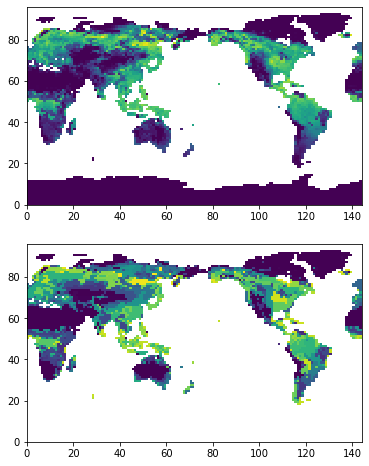

In [75]:
plt.figure(figsize=[6,8])
plt.subplot(211)
plt.pcolormesh(gpp)
plt.subplot(212)
plt.pcolormesh(mapped)

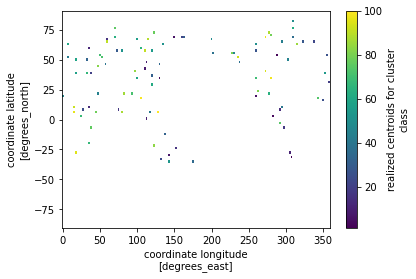

In [15]:
sg.rcent.plot()

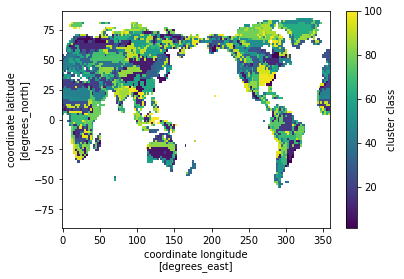

In [32]:
sg.cclass.plot()